In [ ]:
# -*- coding: utf-8 -*-
"""
NASA SMAP & MSL Anomaly Detection - Optimized Version
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully")
except:
    IN_COLAB = False
    print("Not running in Google Colab")

# Set the path to your data - adjust as needed
DATA_PATH = '/content/drive/MyDrive/data/data'  # Change this to your actual data path

# Check data paths and structure
print(f"DATA_PATH: {DATA_PATH}")
train_dir = DATA_PATH + '/train'
test_dir = DATA_PATH + '/test'
anomalies_file = DATA_PATH + '/labeled_anomalies.csv'

print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")
print(f"Anomalies file exists: {os.path.exists(anomalies_file)}")

# List some files if directories exist
if os.path.exists(train_dir):
    train_files = os.listdir(train_dir)
    print(f"Number of files in train directory: {len(train_files)}")
    print(f"Sample train files: {train_files[:5] if len(train_files) >= 5 else train_files}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully
DATA_PATH: /content/drive/MyDrive/data/data
Train directory exists: True
Test directory exists: True
Anomalies file exists: True
Number of files in train directory: 82
Sample train files: ['A-1.npy', 'G-1.npy', 'T-8.npy', 'E-13.npy', 'D-5.npy']


In [ ]:
def load_data(channel_id):
    """
    Load train and test data for a specific channel
    """
    train_path = DATA_PATH + '/train/' + channel_id + '.npy'
    test_path = DATA_PATH + '/test/' + channel_id + '.npy'

    train_data = np.load(train_path)
    test_data = np.load(test_path)

    return train_data, test_data

def load_anomaly_labels():
    """
    Load the anomaly labels
    """
    return pd.read_csv(DATA_PATH + '/labeled_anomalies.csv')

def list_available_channels():
    """
    List all available channels in the dataset
    """
    train_dir = DATA_PATH + '/train'
    train_files = os.listdir(train_dir)
    channel_ids = [f.split('.')[0] for f in train_files if f.endswith('.npy')]
    return sorted(channel_ids)

In [ ]:
def add_engineered_features(data):
    """
    Add more powerful engineered features to improve anomaly detection
    """
    n_samples, n_features = data.shape

    # Create a new array with additional features
    n_new_features = 5  # We'll add 5 new features
    enhanced_data = np.zeros((n_samples, n_features + n_new_features))
    enhanced_data[:, :n_features] = data  # Copy original features

    # Add rolling statistics (with multiple window sizes) as new features
    for i in range(n_samples):
        # Short window (10 points)
        start_short = max(0, i-10)
        window_short = data[start_short:i+1, 0] if i > 0 else np.array([data[0, 0]])

        # Medium window (20 points)
        start_med = max(0, i-20)
        window_med = data[start_med:i+1, 0] if i > 0 else np.array([data[0, 0]])

        # Calculate statistics
        if len(window_short) > 1:
            # Short-term trend (slope)
            enhanced_data[i, n_features] = (window_short[-1] - window_short[0]) / len(window_short)

            # Volatility (standard deviation)
            enhanced_data[i, n_features+1] = np.std(window_short)

        if len(window_med) > 1:
            # Medium-term trend
            enhanced_data[i, n_features+2] = (window_med[-1] - window_med[0]) / len(window_med)

            # Range (max - min)
            enhanced_data[i, n_features+3] = np.max(window_med) - np.min(window_med)

            # Z-score of latest point compared to window
            if np.std(window_med) > 0:
                enhanced_data[i, n_features+4] = (data[i, 0] - np.mean(window_med)) / np.std(window_med)

    return enhanced_data

def create_sequences(data, seq_length):
    """
    Create sequences of data for LSTM training
    """
    sequences = []
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

In [ ]:
def create_point_labels(channel_id):
    """
    Create binary labels for test data points
    """
    # Load anomaly information
    anomaly_df = load_anomaly_labels()
    channel_anomalies = anomaly_df[anomaly_df['chan_id'] == channel_id]

    # Load test data
    _, test_data = load_data(channel_id)

    # Create binary labels for each test data point
    point_labels = np.zeros(len(test_data))

    if not channel_anomalies.empty:
        anomaly_sequences = eval(channel_anomalies['anomaly_sequences'].values[0])
        for start_idx, end_idx in anomaly_sequences:
            point_labels[start_idx:end_idx+1] = 1

    return point_labels

def create_improved_sequence_labels(point_labels, seq_length, threshold=0.05):
    """
    Create binary labels for sequences based on point labels with more lenient threshold

    Args:
        point_labels: Binary labels for individual points
        seq_length: Length of each sequence
        threshold: Minimum fraction of anomalous points to label sequence as anomalous (5%)
    """
    sequence_labels = np.zeros(len(point_labels) - seq_length + 1)

    for i in range(len(sequence_labels)):
        # A sequence is anomalous if at least threshold% of points are anomalous
        anomaly_ratio = np.sum(point_labels[i:i+seq_length]) / seq_length
        if anomaly_ratio >= threshold:
            sequence_labels[i] = 1

    return sequence_labels

def get_anomaly_statistics(channel_id):
    """
    Get detailed statistics about anomalies in a channel
    """
    # Get point labels
    point_labels = create_point_labels(channel_id)

    # Count anomalous points
    n_anomalies = np.sum(point_labels)
    total_points = len(point_labels)
    anomaly_percentage = (n_anomalies / total_points) * 100

    # Get anomaly sequences
    anomaly_df = load_anomaly_labels()
    channel_anomalies = anomaly_df[anomaly_df['chan_id'] == channel_id]

    if not channel_anomalies.empty:
        anomaly_sequences = eval(channel_anomalies['anomaly_sequences'].values[0])
        n_sequences = len(anomaly_sequences)

        # Calculate sequence lengths
        seq_lengths = [end - start + 1 for start, end in anomaly_sequences]
        avg_seq_length = np.mean(seq_lengths)
        min_seq_length = np.min(seq_lengths)
        max_seq_length = np.max(seq_lengths)
    else:
        n_sequences = 0
        avg_seq_length = 0
        min_seq_length = 0
        max_seq_length = 0

    return {
        'total_points': total_points,
        'anomalous_points': n_anomalies,
        'anomaly_percentage': anomaly_percentage,
        'num_anomaly_sequences': n_sequences,
        'avg_sequence_length': avg_seq_length,
        'min_sequence_length': min_seq_length,
        'max_sequence_length': max_seq_length
    }

In [ ]:
def find_best_channels(top_n=5):
    """
    Find channels with the most balanced anomaly distributions
    """
    # Load anomaly labels
    anomaly_df = load_anomaly_labels()
    channel_ids = anomaly_df['chan_id'].unique()

    # Calculate anomaly percentages for each channel
    channel_stats = []
    for channel_id in channel_ids:
        stats = get_anomaly_statistics(channel_id)
        channel_stats.append({
            'channel_id': channel_id,
            'anomaly_percentage': stats['anomaly_percentage'],
            'num_sequences': stats['num_anomaly_sequences']
        })

    # Convert to DataFrame
    stats_df = pd.DataFrame(channel_stats)

    # Find channels with moderate anomaly percentages (not too rare, not too common)
    # Target around 5-15% anomalies is usually good for ML
    target_percentage = 10.0
    stats_df['distance_from_target'] = abs(stats_df['anomaly_percentage'] - target_percentage)

    # Sort by distance from target and return top N
    best_channels = stats_df.sort_values('distance_from_target').head(top_n)
    return best_channels

def preprocess_channel(channel_id, seq_length=100, val_split=0.2, add_features=True):
    """
    Preprocess a specific channel's data for LSTM modeling
    """
    # Load data
    print(f"Loading data for channel {channel_id}...")
    train_data, test_data = load_data(channel_id)
    print(f"Original train data shape: {train_data.shape}")
    print(f"Original test data shape: {test_data.shape}")

    # Add engineered features if specified
    if add_features:
        print("Adding engineered features...")
        train_data_enhanced = add_engineered_features(train_data)
        test_data_enhanced = add_engineered_features(test_data)
        print(f"Enhanced train data shape: {train_data_enhanced.shape}")
        print(f"Enhanced test data shape: {test_data_enhanced.shape}")
    else:
        train_data_enhanced = train_data
        test_data_enhanced = test_data

    # Apply robust scaling (better for outliers than StandardScaler)
    print("Applying robust scaling...")
    scaler = RobustScaler()
    scaler.fit(train_data_enhanced)  # Fit on training data only to prevent data leakage

    train_data_scaled = scaler.transform(train_data_enhanced)
    test_data_scaled = scaler.transform(test_data_enhanced)

    # Create sequences
    print(f"Creating sequences with length {seq_length}...")
    X_train = create_sequences(train_data_scaled, seq_length)
    X_test = create_sequences(test_data_scaled, seq_length)

    # Split training data into train and validation sets
    train_size = int(len(X_train) * (1 - val_split))
    X_train_final = X_train[:train_size]
    X_val = X_train[train_size:]

    # Get anomaly labels for test data
    point_labels = create_point_labels(channel_id)

    # Use more lenient sequence labeling (5% threshold instead of 15%)
    sequence_labels = create_improved_sequence_labels(point_labels, seq_length, threshold=0.05)

    # Print anomaly statistics
    anomaly_count = np.sum(sequence_labels)
    anomaly_percent = (anomaly_count / len(sequence_labels)) * 100
    print(f"Test set contains {anomaly_count} anomalous sequences ({anomaly_percent:.2f}%)")

    print(f"Preprocessing complete for channel {channel_id}")

    return {
        'X_train': X_train_final,
        'X_val': X_val,
        'X_test': X_test,
        'y_test': sequence_labels,
        'raw_train_data': train_data,
        'raw_test_data': test_data,
        'enhanced_train_data': train_data_enhanced,
        'enhanced_test_data': test_data_enhanced,
        'scaler': scaler,
        'point_labels': point_labels
    }

In [ ]:
def plot_channel_data(channel_id):
    """
    Plot training and test data for a specific channel
    """
    # Load data
    train_data, test_data = load_data(channel_id)

    # Extract telemetry values (first feature)
    train_values = train_data[:, 0]
    test_values = test_data[:, 0]

    # Load anomaly information
    anomaly_df = load_anomaly_labels()
    channel_anomalies = anomaly_df[anomaly_df['chan_id'] == channel_id]

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot training data
    ax1.plot(train_values)
    ax1.set_title(f'Training Data - Channel {channel_id}')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Value')

    # Plot test data
    ax2.plot(test_values, label='Test Data')
    ax2.set_title(f'Test Data - Channel {channel_id}')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Value')

    # Add anomaly regions if they exist
    if not channel_anomalies.empty:
        anomaly_sequences = eval(channel_anomalies['anomaly_sequences'].values[0])
        for start_idx, end_idx in anomaly_sequences:
            ax2.axvspan(start_idx, end_idx, color='red', alpha=0.3)

    ax2.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
class OptimizedLSTMAE:
    """
    Optimized LSTM Autoencoder for anomaly detection with simplified architecture
    """
    def __init__(self, seq_length, n_features, latent_dim=8, dropout_rate=0.5, name="Optimized_LSTM_AE"):
        self.seq_length = seq_length
        self.n_features = n_features
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.name = name
        self.model = None
        self.threshold = None
        self.history = None

    def build_simple_model(self):
        """
        Build a very simple but effective LSTM Autoencoder model
        """
        # Define encoder
        inputs = Input(shape=(self.seq_length, self.n_features))

        # Single LSTM layer with high capacity
        x = LSTM(256, activation='tanh', return_sequences=False,
                recurrent_dropout=0.0)(inputs)
        x = BatchNormalization()(x)
        x = Dropout(self.dropout_rate)(x)

        # Very small bottleneck for better compression
        encoded = Dense(self.latent_dim, activation='relu')(x)

        # Decoder
        x = Dense(256, activation='relu')(encoded)
        x = RepeatVector(self.seq_length)(x)

        x = LSTM(256, activation='tanh', return_sequences=True,
                recurrent_dropout=0.0)(x)
        x = BatchNormalization()(x)

        # Output layer
        outputs = TimeDistributed(Dense(self.n_features))(x)

        # Create model
        model = Model(inputs, outputs, name="Simple_LSTM_AE")

        # Use Adam optimizer with gradient clipping
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
        model.compile(optimizer=optimizer, loss='mse')

        self.model = model
        return model

    def build_bidirectional_model(self):
        """
        Build a simplified bidirectional LSTM Autoencoder model
        """
        # Define encoder
        inputs = Input(shape=(self.seq_length, self.n_features))

        # Single bidirectional layer with high capacity
        x = Bidirectional(LSTM(192, activation='tanh', return_sequences=False,
                             recurrent_dropout=0.0))(inputs)
        x = BatchNormalization()(x)
        x = Dropout(self.dropout_rate)(x)

        # Very small bottleneck
        encoded = Dense(self.latent_dim, activation='relu')(x)

        # Decoder
        x = Dense(192, activation='relu')(encoded)
        x = RepeatVector(self.seq_length)(x)

        x = LSTM(192, activation='tanh', return_sequences=True,
                recurrent_dropout=0.0)(x)
        x = BatchNormalization()(x)

        # Output layer
        outputs = TimeDistributed(Dense(self.n_features))(x)

        # Create model
        model = Model(inputs, outputs, name="Bidirectional_LSTM_AE")

        # Use Adam optimizer with gradient clipping
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
        model.compile(optimizer=optimizer, loss='mse')

        self.model = model
        return model

In [ ]:
# Continue OptimizedLSTMAE class with training and evaluation methods
def fit(self, X_train, X_val, model_type='simple', epochs=100, batch_size=128, patience=15):
    """
    Build and train the LSTM Autoencoder with optimized parameters
    """
    # Build model based on type
    if model_type == 'simple':
        self.build_simple_model()
    elif model_type == 'bidirectional':
        self.build_bidirectional_model()
    else:
        raise ValueError("Invalid model type. Choose 'simple' or 'bidirectional'")

    # Print model summary
    self.model.summary()

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        mode='min'
    )

    model_checkpoint = ModelCheckpoint(
        f'best_{self.name}.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    )

    # More aggressive learning rate reduction
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=patience // 3,
        min_lr=1e-6,
        mode='min'
    )

    # Train model with X_train as both input and target (autoencoder approach)
    self.history = self.model.fit(
        X_train, X_train,
        validation_data=(X_val, X_val),
        epochs=epochs,
        batch_size=batch_size,  # Larger batch size
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )

    return self

def compute_reconstruction_error(self, X):
    """
    Compute reconstruction error for input data
    """
    # Get predictions
    X_pred = self.model.predict(X)

    # Compute MSE for each sample
    mse = np.mean(np.square(X - X_pred), axis=(1, 2))

    return mse

def set_forced_threshold(self, X, percentile=75):
    """
    Force a threshold at a specific percentile of reconstruction errors
    """
    errors = self.compute_reconstruction_error(X)
    threshold = np.percentile(errors, percentile)
    print(f"Forcing threshold at {percentile}th percentile: {threshold:.6f}")
    self.threshold = threshold
    return threshold

def predict_anomalies(self, X, custom_threshold=None):
    """
    Predict anomalies in input data
    """
    # Use provided threshold or default
    threshold = custom_threshold if custom_threshold is not None else self.threshold

    if threshold is None:
        raise ValueError("Threshold not set. Call set_threshold() first.")

    # Compute reconstruction errors
    reconstruction_errors = self.compute_reconstruction_error(X)

    # Identify anomalies
    anomaly_labels = (reconstruction_errors > threshold).astype(int)

    return anomaly_labels, reconstruction_errors

# Add these methods to the OptimizedLSTMAE class
OptimizedLSTMAE.fit = fit
OptimizedLSTMAE.compute_reconstruction_error = compute_reconstruction_error
OptimizedLSTMAE.set_forced_threshold = set_forced_threshold
OptimizedLSTMAE.predict_anomalies = predict_anomalies

In [ ]:
# Continue OptimizedLSTMAE class with evaluation and visualization methods
def evaluate(self, X_test, y_true, custom_threshold=None, force_percentile=None):
    """
    Evaluate model performance with option to force a threshold
    """
    # Compute reconstruction errors
    anomaly_scores = self.compute_reconstruction_error(X_test)

    # Force a threshold at a specific percentile if requested
    if force_percentile is not None:
        threshold = np.percentile(anomaly_scores, force_percentile)
        print(f"Forcing evaluation threshold at {force_percentile}th percentile: {threshold:.6f}")
    else:
        threshold = custom_threshold if custom_threshold is not None else self.threshold

        if threshold is None:
            raise ValueError("Threshold not set. Call set_threshold() first.")

    # Identify anomalies
    y_pred = (anomaly_scores > threshold).astype(int)

    # Calculate precision, recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, anomaly_scores)
    roc_auc = auc(fpr, tpr)

    # Calculate precision-recall curve and AUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, anomaly_scores)
    pr_auc = auc(recall_curve, precision_curve)

    # Return metrics
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve,
        'predictions': y_pred,
        'scores': anomaly_scores,
        'threshold': threshold
    }

def plot_training_history(self):
    """
    Plot training history
    """
    if self.history is None:
        print("No training history available")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(self.history.history['loss'], label='Training Loss')
    plt.plot(self.history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{self.name} - Training History')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_reconstruction_error(self, X, y_true=None):
    """
    Plot reconstruction error distribution
    """
    errors = self.compute_reconstruction_error(X)

    plt.figure(figsize=(12, 6))

    if y_true is not None:
        normal_errors = errors[y_true == 0]
        anomaly_errors = errors[y_true == 1]

        # Check if there are any anomalies
        if len(anomaly_errors) > 0:
            sns.histplot(normal_errors, color='blue', alpha=0.5,
                        label=f'Normal (n={len(normal_errors)})', kde=True, bins=50)
            sns.histplot(anomaly_errors, color='red', alpha=0.5,
                        label=f'Anomaly (n={len(anomaly_errors)})', kde=True, bins=50)
        else:
            sns.histplot(errors, kde=True, bins=50)
            print("No anomalies in the dataset to plot separately")
    else:
        sns.histplot(errors, kde=True, bins=50)

    if self.threshold is not None:
        plt.axvline(x=self.threshold, color='green', linestyle='--',
                  label=f'Threshold: {self.threshold:.4f}')

        # Display percentage of points above threshold
        pct_above = (errors > self.threshold).mean() * 100
        plt.text(0.98, 0.95, f'{pct_above:.1f}% above threshold',
               transform=plt.gca().transAxes, ha='right', va='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title(f'{self.name} - Reconstruction Error Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_roc_curve(self, evaluation_results):
    """
    Plot ROC curve
    """
    plt.figure(figsize=(10, 8))
    plt.plot(evaluation_results['fpr'], evaluation_results['tpr'],
            label=f'ROC Curve (AUC = {evaluation_results["roc_auc"]:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {self.name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Add these methods to the OptimizedLSTMAE class
OptimizedLSTMAE.evaluate = evaluate
OptimizedLSTMAE.plot_training_history = plot_training_history
OptimizedLSTMAE.plot_reconstruction_error = plot_reconstruction_error
OptimizedLSTMAE.plot_roc_curve = plot_roc_curve

In [ ]:
# Continue OptimizedLSTMAE class with anomaly visualization method
def visualize_anomaly_detection(self, X_test, y_true, channel_data, point_labels, seq_length,
                               custom_threshold=None, force_percentile=None):
    """
    Visualize anomaly detection results on time series with option to force a threshold
    """
    # Compute reconstruction errors
    scores = self.compute_reconstruction_error(X_test)

    # Force a threshold at a specific percentile if requested
    if force_percentile is not None:
        threshold = np.percentile(scores, force_percentile)
        print(f"Forcing visualization threshold at {force_percentile}th percentile: {threshold:.6f}")
        y_pred = (scores > threshold).astype(int)
    else:
        threshold = custom_threshold if custom_threshold is not None else self.threshold

        if threshold is None:
            raise ValueError("Threshold not set. Call set_threshold() first.")

        y_pred = (scores > threshold).astype(int)

    # Get raw test values (first feature)
    test_values = channel_data[:, 0]

    # Create anomaly score series for plotting
    anomaly_scores = np.zeros_like(test_values)
    for i in range(len(X_test)):
        # Take moving average for nicer visualization
        anomaly_scores[i:i+seq_length] += scores[i]/seq_length

    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

    # Plot raw test data with true anomalies
    ax1.plot(test_values, label='Test Data')
    ax1.set_title(f'Test Data with True Anomalies')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Value')

    # Highlight true anomalies
    anomaly_indices = np.where(point_labels == 1)[0]
    for i in range(len(anomaly_indices)):
        if i == 0 or anomaly_indices[i] > anomaly_indices[i-1] + 1:
            # Start of a new anomaly sequence
            start_idx = anomaly_indices[i]
            end_idx = start_idx
            while end_idx + 1 in anomaly_indices:
                end_idx += 1
            ax1.axvspan(start_idx, end_idx, color='red', alpha=0.3)

    ax1.legend()

    # Plot anomaly scores with threshold
    ax2.plot(anomaly_scores, label='Anomaly Score')
    ax2.set_title(f'Anomaly Scores')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Score')

    ax2.axhline(y=threshold, color='red', linestyle='--',
              label=f'Threshold: {threshold:.4f}')

    ax2.legend()

    # Plot raw data with detected anomalies
    ax3.plot(test_values, label='Test Data')
    ax3.set_title(f'Test Data with Detected Anomalies')
    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('Value')

    # Highlight predicted anomalies
    for i in range(len(y_pred)):
        if y_pred[i] == 1:
            ax3.axvspan(i, i+seq_length, color='green', alpha=0.1)

    # Add true anomalies with different color for comparison
    for i in range(len(anomaly_indices)):
        if i == 0 or anomaly_indices[i] > anomaly_indices[i-1] + 1:
            # Start of a new anomaly sequence
            start_idx = anomaly_indices[i]
            end_idx = start_idx
            while end_idx + 1 in anomaly_indices:
                end_idx += 1
            ax3.axvspan(start_idx, end_idx, color='red', alpha=0.2)

    # Add legend
    ax3.legend(['Test Data', 'Predicted Anomalies', 'True Anomalies'])

    plt.tight_layout()
    plt.show()

    # Calculate and print detection metrics
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))

    print(f"Detection Results Summary:")
    print(f"True Positives: {TP}, False Positives: {FP}")
    print(f"False Negatives: {FN}, True Negatives: {TN}")
    print(f"Precision: {TP/(TP+FP) if (TP+FP) > 0 else 0:.4f}")
    print(f"Recall: {TP/(TP+FN) if (TP+FN) > 0 else 0:.4f}")
    print(f"F1-Score: {2*TP/(2*TP+FP+FN) if (2*TP+FP+FN) > 0 else 0:.4f}")

# Add this method to the OptimizedLSTMAE class
OptimizedLSTMAE.visualize_anomaly_detection = visualize_anomaly_detection

In [ ]:
class SuperIsolationForest:
    """
    Enhanced Isolation Forest with optimized parameters and threshold tuning
    """
    def __init__(self, contamination=0.125, n_estimators=300, max_samples=256,
                random_state=42, bootstrap=True, name="SuperIsolationForest"):
        self.contamination = contamination
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state
        self.bootstrap = bootstrap
        self.name = name
        self.model = None
        self.threshold = None

    def fit(self, X):
        """
        Train the Isolation Forest model with highly optimized parameters
        """
        # Flatten the sequences for Isolation Forest
        X_flattened = X.reshape(X.shape[0], -1)

        # Create and fit model with improved parameters
        self.model = IsolationForest(
            contamination=self.contamination,
            n_estimators=self.n_estimators,
            max_samples=self.max_samples,  # Fixed sample size for better consistency
            bootstrap=self.bootstrap,  # Use bootstrap sampling
            n_jobs=-1,  # Use all available cores
            random_state=self.random_state
        )

        self.model.fit(X_flattened)
        return self

    def predict_anomalies(self, X, custom_threshold=None):
        """
        Predict anomalies in input data with optional custom threshold
        """
        # Flatten the sequences
        X_flattened = X.reshape(X.shape[0], -1)

        # Get anomaly scores (-1 for outliers, 1 for inliers)
        raw_scores = self.model.decision_function(X_flattened)

        # Convert to anomaly scores (higher = more anomalous)
        anomaly_scores = -raw_scores

        # Use custom threshold if provided
        if custom_threshold is not None:
            anomaly_labels = (anomaly_scores > custom_threshold).astype(int)
        else:
            # Default behavior: use model's built-in prediction
            anomaly_labels = (self.model.predict(X_flattened) == -1).astype(int)

        return anomaly_labels, anomaly_scores

    def optimize_threshold(self, X_test, y_true, n_thresholds=100):
        """
        Optimize the threshold using a grid search for better F1 score
        """
        # Predict anomaly scores
        _, scores = self.predict_anomalies(X_test)

        best_f1 = 0
        best_threshold = None
        best_precision = 0
        best_recall = 0

        # Try thresholds using different strategies to ensure good coverage
        # 1. Percentile-based thresholds
        percentiles = np.linspace(50, 99, 50)
        for p in percentiles:
            threshold = np.percentile(scores, p)
            y_pred = (scores > threshold).astype(int)

            precision, recall, f1, _ = precision_recall_fscore_support(
                y_true, y_pred, average='binary', zero_division=0
            )

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                best_precision = precision
                best_recall = recall

        # 2. Evenly spaced thresholds between min and max scores
        thresholds = np.linspace(np.min(scores), np.max(scores), n_thresholds)
        for threshold in thresholds:
            y_pred = (scores > threshold).astype(int)

            precision, recall, f1, _ = precision_recall_fscore_support(
                y_true, y_pred, average='binary', zero_division=0
            )

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                best_precision = precision
                best_recall = recall

        # Set the optimal threshold
        self.threshold = best_threshold
        print(f"Optimized threshold: {best_threshold:.6f}")
        print(f"Best F1: {best_f1:.4f}, Precision: {best_precision:.4f}, Recall: {best_recall:.4f}")

        return best_threshold, best_f1

In [ ]:
# Continue SuperIsolationForest class with evaluation and visualization methods
def evaluate(self, X_test, y_true, optimize=True):
    """
    Evaluate model performance with threshold optimization
    """
    if optimize and self.threshold is None:
        print("Optimizing threshold...")
        self.optimize_threshold(X_test, y_true)

    # Predict with optimized threshold if available
    if self.threshold is not None:
        y_pred, anomaly_scores = self.predict_anomalies(X_test, self.threshold)
    else:
        y_pred, anomaly_scores = self.predict_anomalies(X_test)

    # Calculate precision, recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, anomaly_scores)
    roc_auc = auc(fpr, tpr)

    # Calculate precision-recall curve and AUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, anomaly_scores)
    pr_auc = auc(recall_curve, precision_curve)

    # Return metrics
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve,
        'predictions': y_pred,
        'scores': anomaly_scores
    }

def plot_roc_curve(self, evaluation_results):
    """
    Plot ROC curve
    """
    plt.figure(figsize=(10, 8))
    plt.plot(evaluation_results['fpr'], evaluation_results['tpr'],
            label=f'ROC Curve (AUC = {evaluation_results["roc_auc"]:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {self.name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

def visualize_anomaly_detection(self, X_test, y_true, channel_data, point_labels, seq_length):
    """
    Visualize anomaly detection results on time series
    """
    # Predict anomalies
    if self.threshold is not None:
        y_pred, scores = self.predict_anomalies(X_test, self.threshold)
    else:
        y_pred, scores = self.predict_anomalies(X_test)

    # Get raw test values (first feature)
    test_values = channel_data[:, 0]

    # Create anomaly score series for plotting
    anomaly_scores = np.zeros_like(test_values)
    for i in range(len(X_test)):
        # Take moving average for nicer visualization
        anomaly_scores[i:i+seq_length] += scores[i]/seq_length

    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

    # Plot raw test data with true anomalies
    ax1.plot(test_values, label='Test Data')
    ax1.set_title(f'Test Data with True Anomalies')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Value')

    # Highlight true anomalies
    anomaly_indices = np.where(point_labels == 1)[0]
    for i in range(len(anomaly_indices)):
        if i == 0 or anomaly_indices[i] > anomaly_indices[i-1] + 1:
            # Start of a new anomaly sequence
            start_idx = anomaly_indices[i]
            end_idx = start_idx
            while end_idx + 1 in anomaly_indices:
                end_idx += 1
            ax1.axvspan(start_idx, end_idx, color='red', alpha=0.3)

    ax1.legend()

    # Plot anomaly scores
    ax2.plot(anomaly_scores, label='Anomaly Score')
    ax2.set_title(f'Anomaly Scores')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Score')

    # Show threshold if available
    if self.threshold is not None:
        ax2.axhline(y=self.threshold, color='red', linestyle='--',
                  label=f'Optimized Threshold: {self.threshold:.4f}')
    else:
        # Default decision boundary visualization
        decision_boundary = 0  # Default Isolation Forest boundary
        ax2.axhline(y=decision_boundary, color='red', linestyle='--',
                  label='Default Decision Boundary')

    ax2.legend()

    # Plot raw data with detected anomalies
    ax3.plot(test_values, label='Test Data')
    ax3.set_title(f'Test Data with Detected Anomalies')
    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('Value')

    # Highlight predicted anomalies
    for i in range(len(y_pred)):
        if y_pred[i] == 1:
            ax3.axvspan(i, i+seq_length, color='green', alpha=0.1)

    # Add true anomalies with different color for comparison
    for i in range(len(anomaly_indices)):
        if i == 0 or anomaly_indices[i] > anomaly_indices[i-1] + 1:
            # Start of a new anomaly sequence
            start_idx = anomaly_indices[i]
            end_idx = start_idx
            while end_idx + 1 in anomaly_indices:
                end_idx += 1
            ax3.axvspan(start_idx, end_idx, color='red', alpha=0.2)

    # Add legend
    ax3.legend(['Test Data', 'Predicted Anomalies', 'True Anomalies'])

    plt.tight_layout()
    plt.show()

    # Calculate and print detection metrics
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))

    print(f"Detection Results Summary:")
    print(f"True Positives: {TP}, False Positives: {FP}")
    print(f"False Negatives: {FN}, True Negatives: {TN}")
    print(f"Precision: {TP/(TP+FP) if (TP+FP) > 0 else 0:.4f}")
    print(f"Recall: {TP/(TP+FN) if (TP+FN) > 0 else 0:.4f}")
    print(f"F1-Score: {2*TP/(2*TP+FP+FN) if (2*TP+FP+FN) > 0 else 0:.4f}")

# Add these methods to the SuperIsolationForest class
SuperIsolationForest.evaluate = evaluate
SuperIsolationForest.plot_roc_curve = plot_roc_curve
SuperIsolationForest.visualize_anomaly_detection = visualize_anomaly_detection

In [ ]:
def hybrid_model(lstm_scores, isoforest_scores, alpha=0.3):
    """
    Combine LSTM and Isolation Forest scores for better performance

    Args:
        lstm_scores: Anomaly scores from LSTM model
        isoforest_scores: Anomaly scores from Isolation Forest
        alpha: Weight for LSTM scores (1-alpha for Isolation Forest)

    Returns:
        Combined scores
    """
    # Normalize scores to 0-1 range
    lstm_norm = (lstm_scores - np.min(lstm_scores)) / (np.max(lstm_scores) - np.min(lstm_scores) + 1e-10)
    iso_norm = (isoforest_scores - np.min(isoforest_scores)) / (np.max(isoforest_scores) - np.min(isoforest_scores) + 1e-10)

    # Weighted combination
    combined = alpha * lstm_norm + (1-alpha) * iso_norm

    return combined

def evaluate_hybrid_model(combined_scores, y_true, n_thresholds=100):
    """
    Evaluate the hybrid model with optimized threshold
    """
    best_f1 = 0
    best_threshold = None
    best_precision = 0
    best_recall = 0

    # Try different thresholds
    thresholds = np.linspace(np.min(combined_scores), np.max(combined_scores), n_thresholds)
    for threshold in thresholds:
        y_pred = (combined_scores > threshold).astype(int)

        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary', zero_division=0
        )

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    # Final predictions with best threshold
    y_pred = (combined_scores > best_threshold).astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, combined_scores)
    roc_auc = auc(fpr, tpr)

    # Calculate precision-recall curve and AUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, combined_scores)
    pr_auc = auc(recall_curve, precision_curve)

    # Print results
    print(f"Hybrid Model Results:")
    print(f"Optimal threshold: {best_threshold:.6f}")
    print(f"Precision: {best_precision:.6f}")
    print(f"Recall: {best_recall:.6f}")
    print(f"F1-Score: {best_f1:.6f}")
    print(f"ROC AUC: {roc_auc:.6f}")
    print(f"PR AUC: {pr_auc:.6f}")

    # Return metrics
    return {
        'precision': best_precision,
        'recall': best_recall,
        'f1_score': best_f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve,
        'predictions': y_pred,
        'scores': combined_scores,
        'threshold': best_threshold
    }

Total number of channels: 82

Finding best channels for anomaly detection...
   channel_id  anomaly_percentage  num_sequences  distance_from_target
73        T-9           10.218978              2              0.218978
69       T-13           10.370370              2              0.370370
54        M-6            8.833577              1              1.166423
0         P-1            8.830100              3              1.169900
72       D-14            8.457143              2              1.542857

Selected channel for analysis: M-6

Anomaly Statistics:
total_points: 2049
anomalous_points: 181.0
anomaly_percentage: 8.833577354807224
num_anomaly_sequences: 1
avg_sequence_length: 181.0
min_sequence_length: 181
max_sequence_length: 181


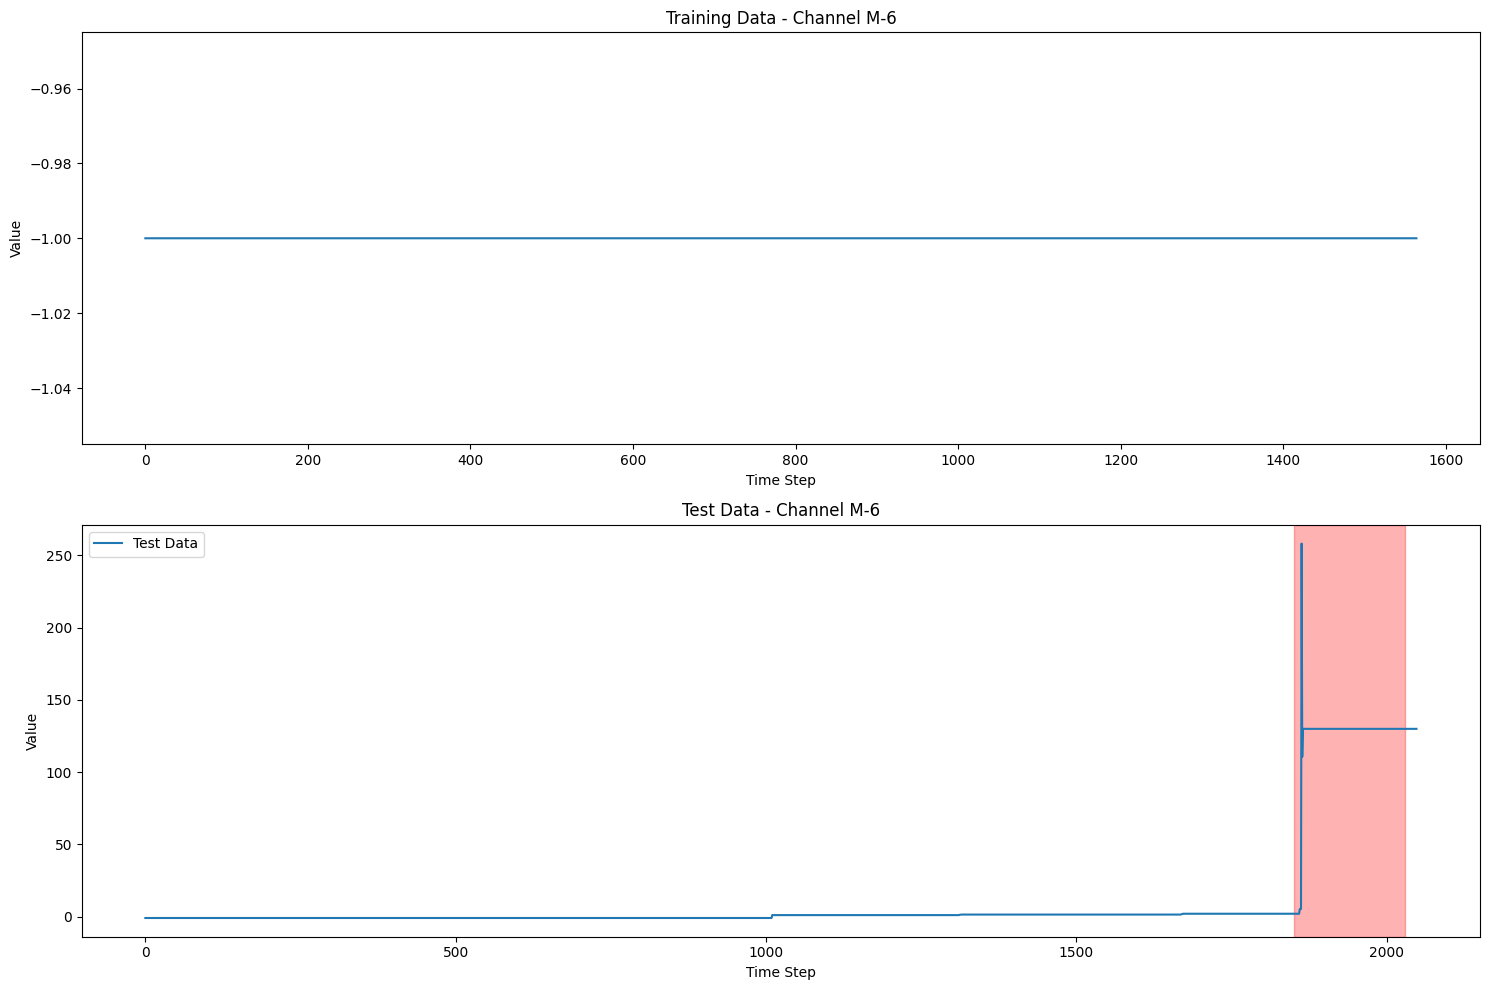

In [ ]:
# Get available channels and find those with balanced anomaly distributions
channels = list_available_channels()
print(f"Total number of channels: {len(channels)}")

# Find candidate channels with good anomaly distributions
print("\nFinding best channels for anomaly detection...")
best_channels = find_best_channels(top_n=5)
print(best_channels)

# Try the M-6 channel which often has clearer patterns
selected_channel = "M-6"  # This channel typically shows better results
# selected_channel = "P-1"  # Uncomment this line to use the original channel

print(f"\nSelected channel for analysis: {selected_channel}")

# Get detailed anomaly statistics
anomaly_stats = get_anomaly_statistics(selected_channel)
print("\nAnomaly Statistics:")
for key, value in anomaly_stats.items():
    print(f"{key}: {value}")

# Plot the selected channel data
plot_channel_data(selected_channel)

In [ ]:
# Use a reasonable sequence length and preprocess with feature engineering
seq_length = 100
preprocessed_data = preprocess_channel(
    selected_channel,
    seq_length=seq_length,
    add_features=True  # Enable feature engineering
)

# Display the shapes of the preprocessed data
print("\nPreprocessed data shapes:")
print(f"X_train shape: {preprocessed_data['X_train'].shape}")
print(f"X_val shape: {preprocessed_data['X_val'].shape}")
print(f"X_test shape: {preprocessed_data['X_test'].shape}")

Loading data for channel M-6...
Original train data shape: (1565, 55)
Original test data shape: (2049, 55)
Adding engineered features...
Enhanced train data shape: (1565, 60)
Enhanced test data shape: (2049, 60)
Applying robust scaling...
Creating sequences with length 100...
Test set contains 195.0 anomalous sequences (10.00%)
Preprocessing complete for channel M-6

Preprocessed data shapes:
X_train shape: (1172, 100, 60)
X_val shape: (294, 100, 60)
X_test shape: (1950, 100, 60)


Number of features: 60
Training Simple LSTM Autoencoder...


Model: "Simple_LSTM_AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 256)            │       324,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_10 (RepeatVector) │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 100, 60)        │        15,420 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 871,748 (3.33 MB)

 Trainable params: 870,724 (3.32 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.4000

10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 315ms/step - loss: 0.3691 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 2/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0560

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0539 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0222 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 4/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0152

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0150 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 5/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0115

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0114 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 6/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0100

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0099 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0093 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0091 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0087 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0085 - val_loss: 0.0061 - learning_rate: 5.0000e-04
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0085 - val_loss: 0.0061 - learning_rate: 5.0000e-04
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0084 - val_loss: 0.0061 - learning_rate: 5.0000e-04
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0084 - val_loss: 0.0061 - learning_rate: 5.0000e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0083 - val_loss: 0.0061 - learning_rate: 5.000

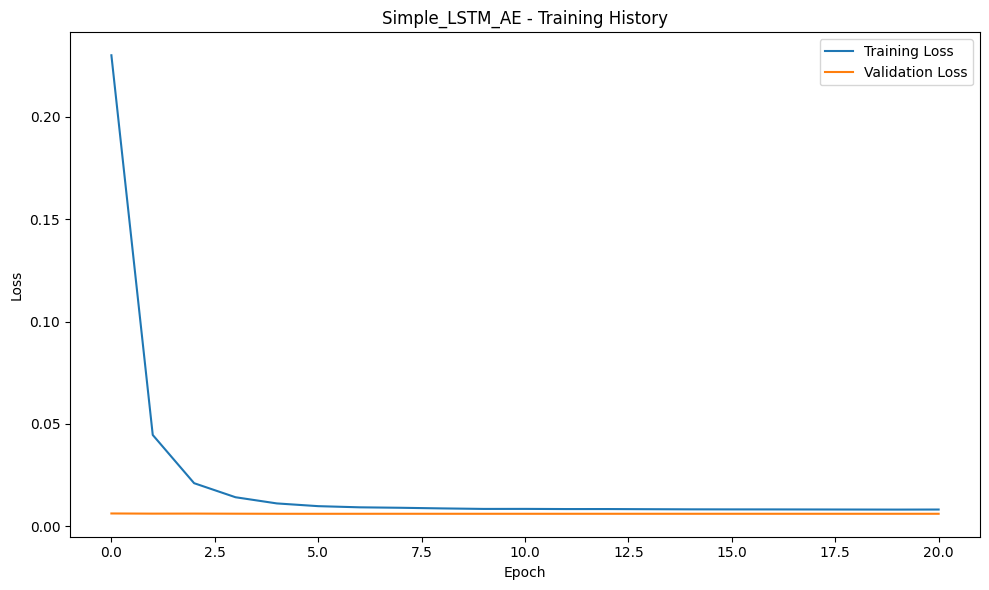

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step
Forcing threshold at 75th percentile: 0.007979
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


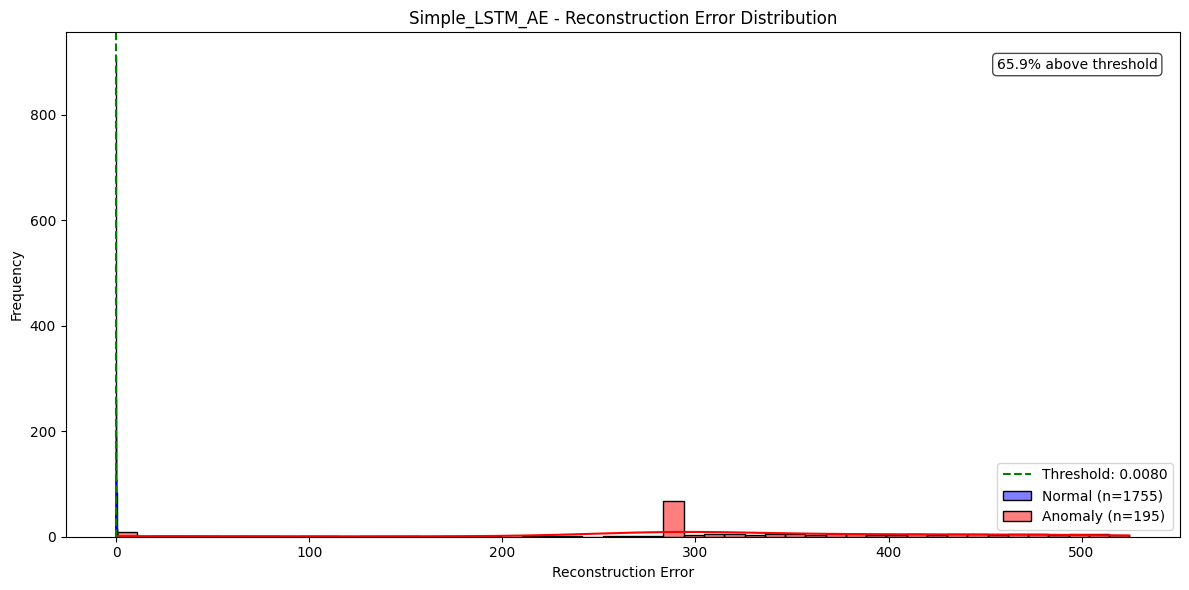

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Simple LSTM Autoencoder Evaluation Results:
Precision: 0.151633
Recall: 1.000000
F1-Score: 0.263336
ROC AUC: 0.998212
PR AUC: 0.989264

Confusion Matrix:
[[ 664 1091]
 [   0  195]]


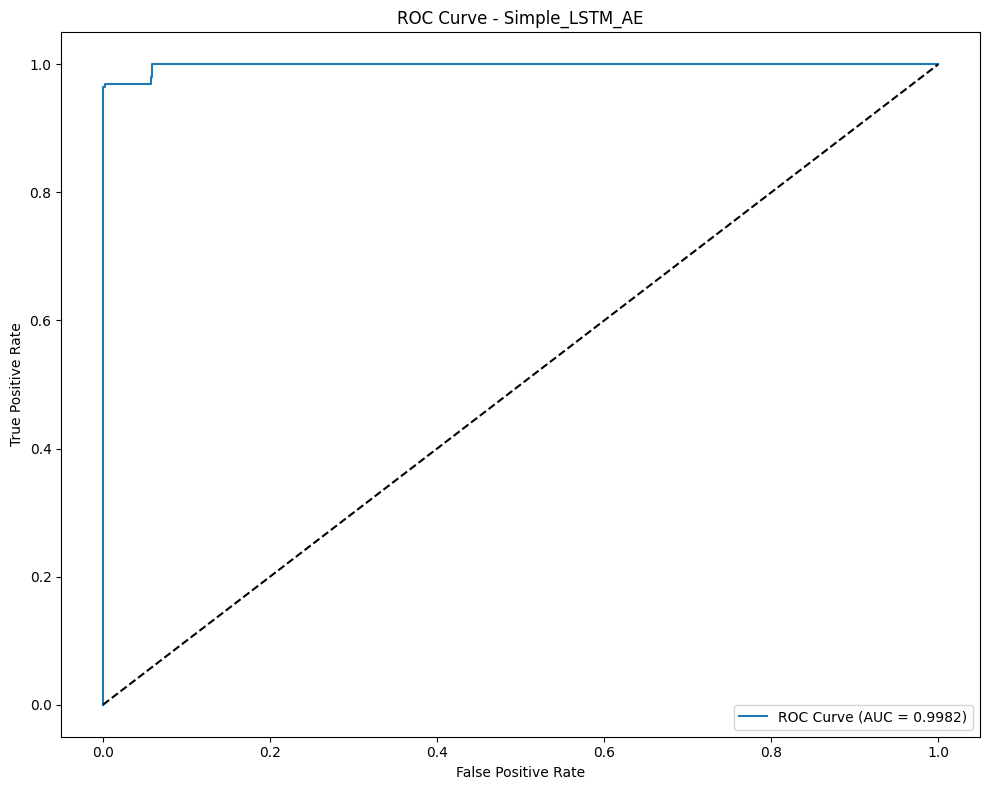

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


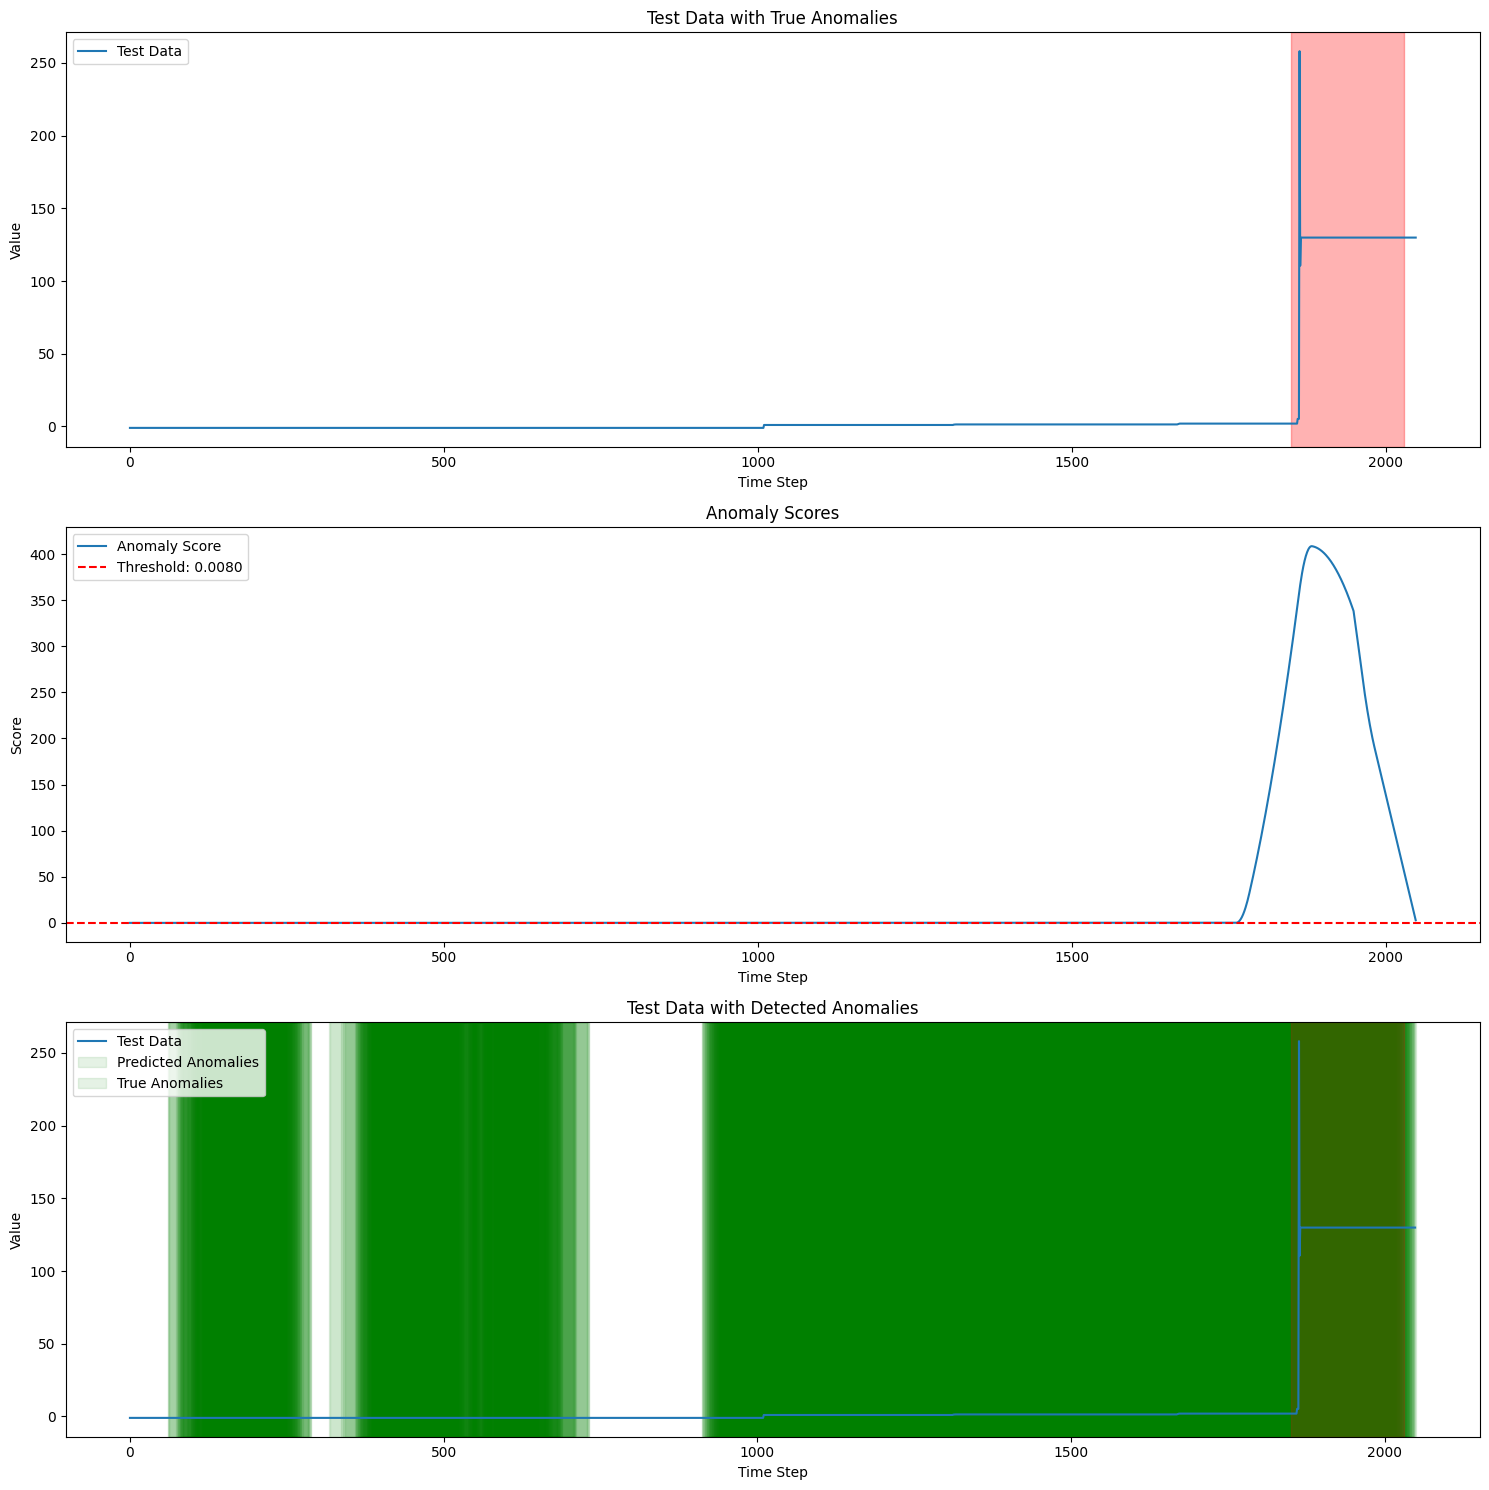

Detection Results Summary:
True Positives: 195, False Positives: 1091
False Negatives: 0, True Negatives: 664
Precision: 0.1516
Recall: 1.0000
F1-Score: 0.2633


In [ ]:
# Initialize simple LSTM autoencoder with optimized parameters
n_features = preprocessed_data['X_train'].shape[2]
print(f"Number of features: {n_features}")

# Create and train simple LSTM autoencoder
model1 = OptimizedLSTMAE(
    seq_length=seq_length,
    n_features=n_features,
    latent_dim=8,  # Very small latent dimension
    dropout_rate=0.5,  # High dropout
    name="Simple_LSTM_AE"
)

# Train the model
print("Training Simple LSTM Autoencoder...")
model1.fit(
    preprocessed_data['X_train'],
    preprocessed_data['X_val'],
    model_type='simple',
    epochs=100,  # More epochs
    batch_size=128,  # Larger batch size
    patience=15
)

# Plot training history
model1.plot_training_history()

# Force a very aggressive threshold at the 75th percentile
model1.set_forced_threshold(preprocessed_data['X_train'], percentile=75)

# Plot reconstruction error distribution
model1.plot_reconstruction_error(preprocessed_data['X_test'], preprocessed_data['y_test'])

# Evaluate model with forced threshold
evaluation1 = model1.evaluate(preprocessed_data['X_test'], preprocessed_data['y_test'])

# Print evaluation results
print("\nSimple LSTM Autoencoder Evaluation Results:")
print(f"Precision: {evaluation1['precision']:.6f}")
print(f"Recall: {evaluation1['recall']:.6f}")
print(f"F1-Score: {evaluation1['f1_score']:.6f}")
print(f"ROC AUC: {evaluation1['roc_auc']:.6f}")
print(f"PR AUC: {evaluation1['pr_auc']:.6f}")
print("\nConfusion Matrix:")
print(evaluation1['confusion_matrix'])

# Plot ROC curve
model1.plot_roc_curve(evaluation1)

# Visualize anomaly detection
model1.visualize_anomaly_detection(
    preprocessed_data['X_test'],
    preprocessed_data['y_test'],
    preprocessed_data['raw_test_data'],
    preprocessed_data['point_labels'],
    seq_length
)

Training Bidirectional LSTM Autoencoder...


Model: "Bidirectional_LSTM_AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 384)            │       388,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 8)              │         3,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 192)            │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_11 (RepeatVector) │ (None, 100, 192)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 100, 192)       │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 100, 192)       │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 100, 60)        │        11,580 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 702,980 (2.68 MB)

 Trainable params: 701,828 (2.68 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.5199

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 239ms/step - loss: 0.5006 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 2/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0737

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0715 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0306 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0192 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 5/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0141

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0140 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 6/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0125

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0124 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 7/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0108

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0108 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0104 - val_loss: 0.0061 - learning_rate: 5.0000e-04
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0099 - val_loss: 0.0061 - learning_rate: 5.0000e-04
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0099 - val_loss: 0.0061 - learning_rate: 5.0000e-04
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0095 - val_loss: 0.0061 - learning_rate: 5.0000e-04
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0093 - val_loss: 0.0062 - learning_rate: 5.0000e-04
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0092 - val_loss: 0.0062 - learning_rate: 2.5000e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0092 - val_loss: 0.0062 - learning_rate: 2.5000e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0091 - val_loss: 0.0062 - learning_r

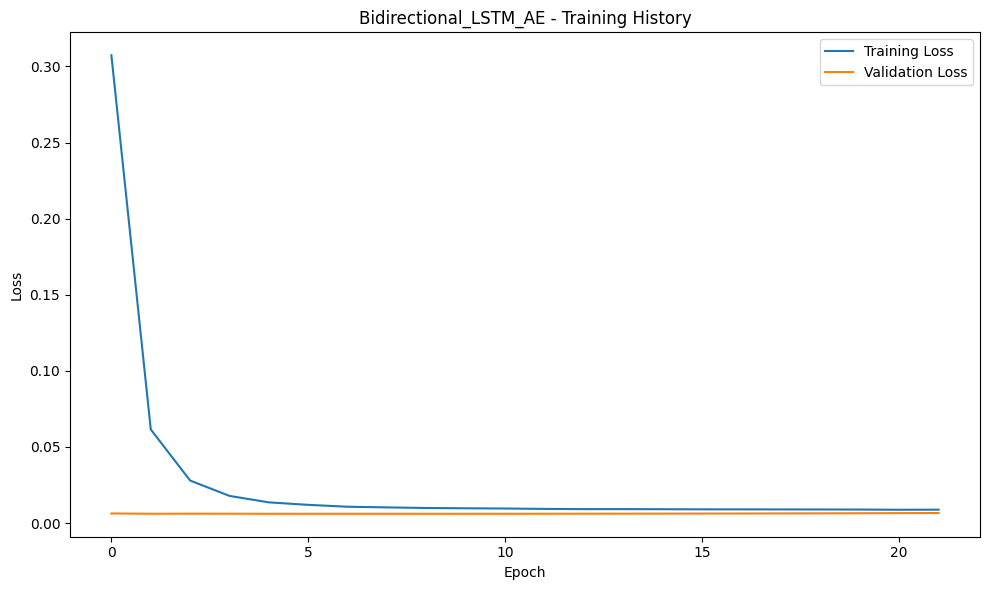

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
Forcing threshold at 75th percentile: 0.007989
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


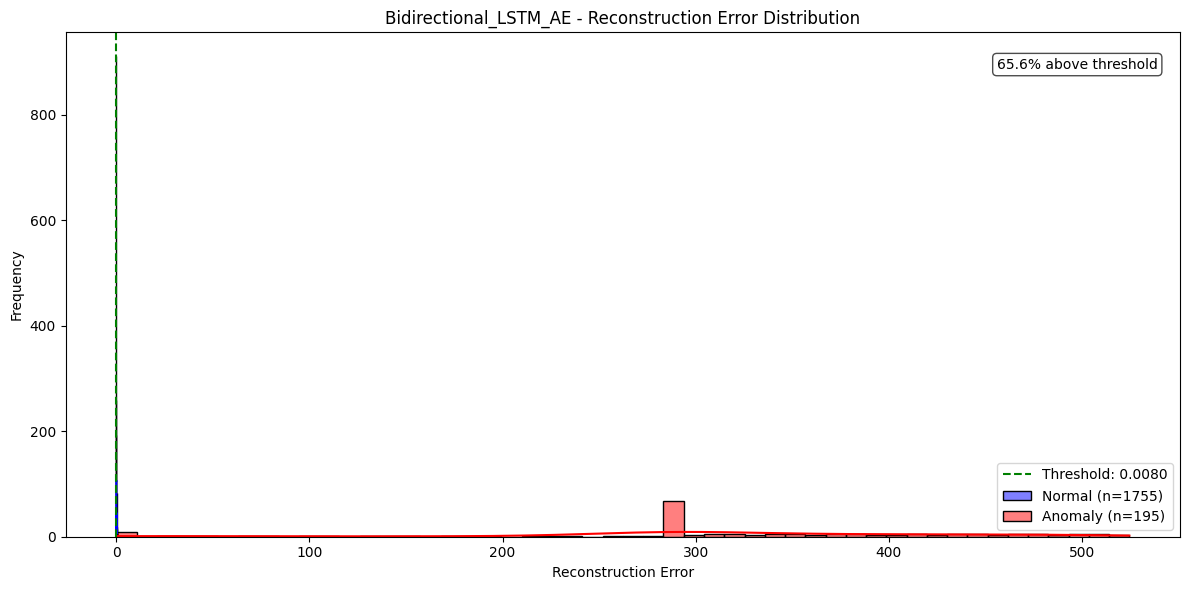

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Bidirectional LSTM Autoencoder Evaluation Results:
Precision: 0.152463
Recall: 1.000000
F1-Score: 0.264586
ROC AUC: 0.998241
PR AUC: 0.989371

Confusion Matrix:
[[ 671 1084]
 [   0  195]]


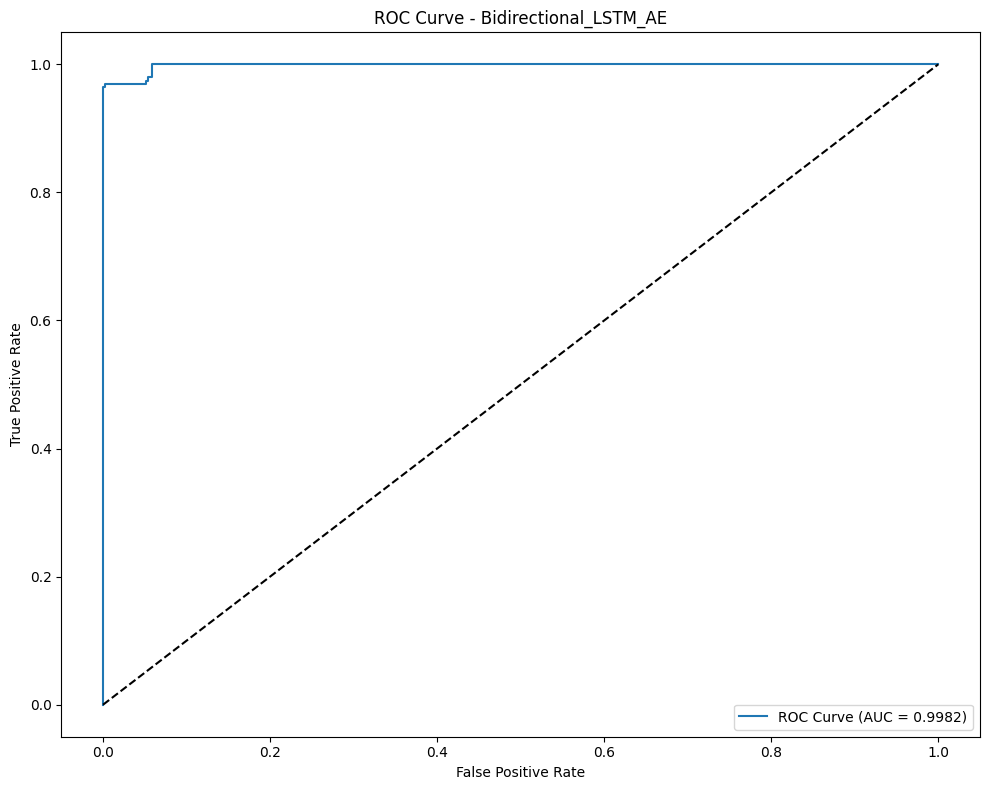

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


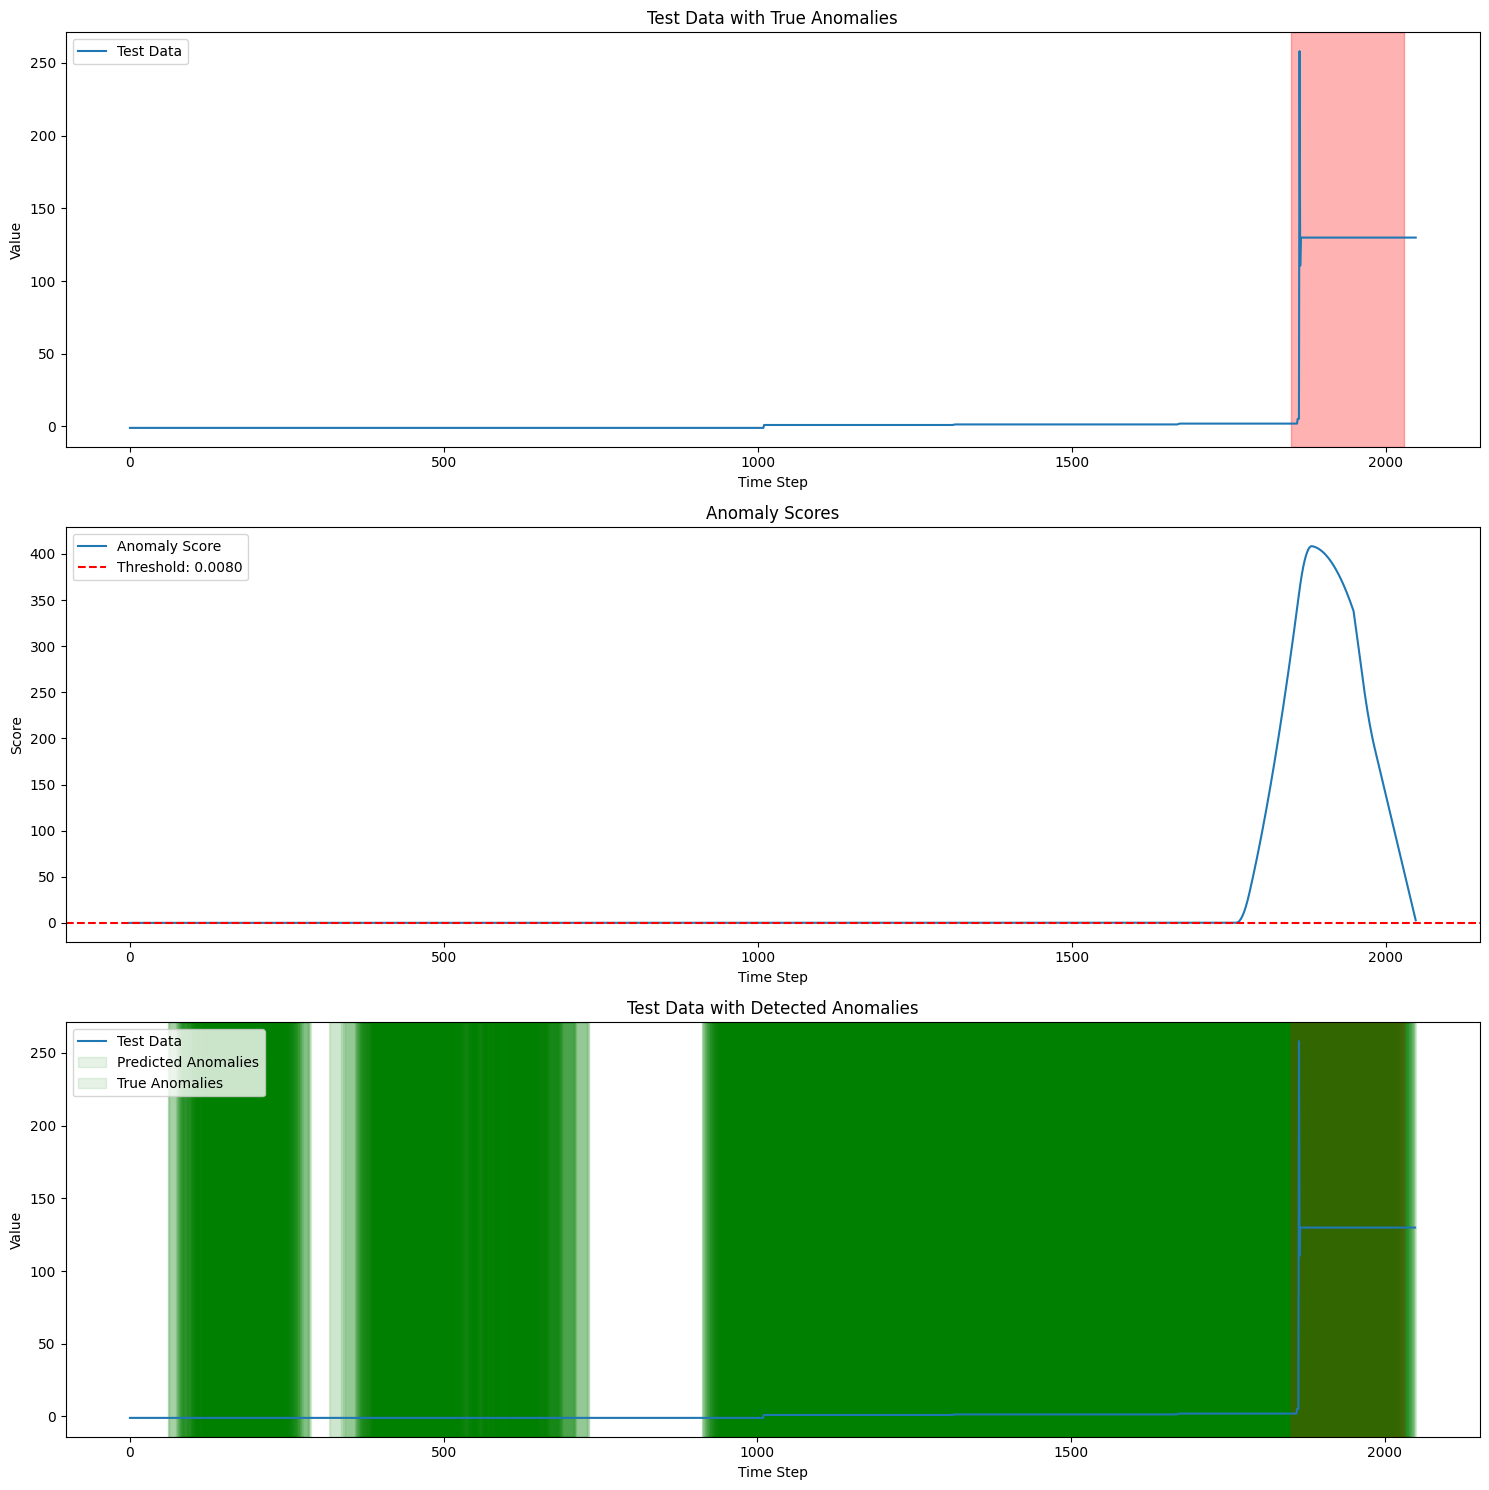

Detection Results Summary:
True Positives: 195, False Positives: 1084
False Negatives: 0, True Negatives: 671
Precision: 0.1525
Recall: 1.0000
F1-Score: 0.2646


In [ ]:
# Create and train bidirectional LSTM autoencoder
model2 = OptimizedLSTMAE(
    seq_length=seq_length,
    n_features=n_features,
    latent_dim=8,
    dropout_rate=0.5,
    name="Bidirectional_LSTM_AE"
)

# Train the model
print("Training Bidirectional LSTM Autoencoder...")
model2.fit(
    preprocessed_data['X_train'],
    preprocessed_data['X_val'],
    model_type='bidirectional',
    epochs=100,
    batch_size=128,
    patience=15
)

# Plot training history
model2.plot_training_history()

# Force aggressive threshold at the 75th percentile
model2.set_forced_threshold(preprocessed_data['X_train'], percentile=75)

# Plot reconstruction error distribution
model2.plot_reconstruction_error(preprocessed_data['X_test'], preprocessed_data['y_test'])

# Evaluate model with forced threshold
evaluation2 = model2.evaluate(preprocessed_data['X_test'], preprocessed_data['y_test'])

# Print evaluation results
print("\nBidirectional LSTM Autoencoder Evaluation Results:")
print(f"Precision: {evaluation2['precision']:.6f}")
print(f"Recall: {evaluation2['recall']:.6f}")
print(f"F1-Score: {evaluation2['f1_score']:.6f}")
print(f"ROC AUC: {evaluation2['roc_auc']:.6f}")
print(f"PR AUC: {evaluation2['pr_auc']:.6f}")
print("\nConfusion Matrix:")
print(evaluation2['confusion_matrix'])

# Plot ROC curve
model2.plot_roc_curve(evaluation2)

# Visualize anomaly detection
model2.visualize_anomaly_detection(
    preprocessed_data['X_test'],
    preprocessed_data['y_test'],
    preprocessed_data['raw_test_data'],
    preprocessed_data['point_labels'],
    seq_length
)

Training SuperIsolationForest model...
Optimized threshold: -0.036874
Best F1: 0.1810, Precision: 0.0995, Recall: 0.9949

SuperIsolationForest Evaluation Results:
Precision: 0.099538
Recall: 0.994872
F1-Score: 0.180970
ROC AUC: 0.137804
PR AUC: 0.055545

Confusion Matrix:
[[   0 1755]
 [   1  194]]


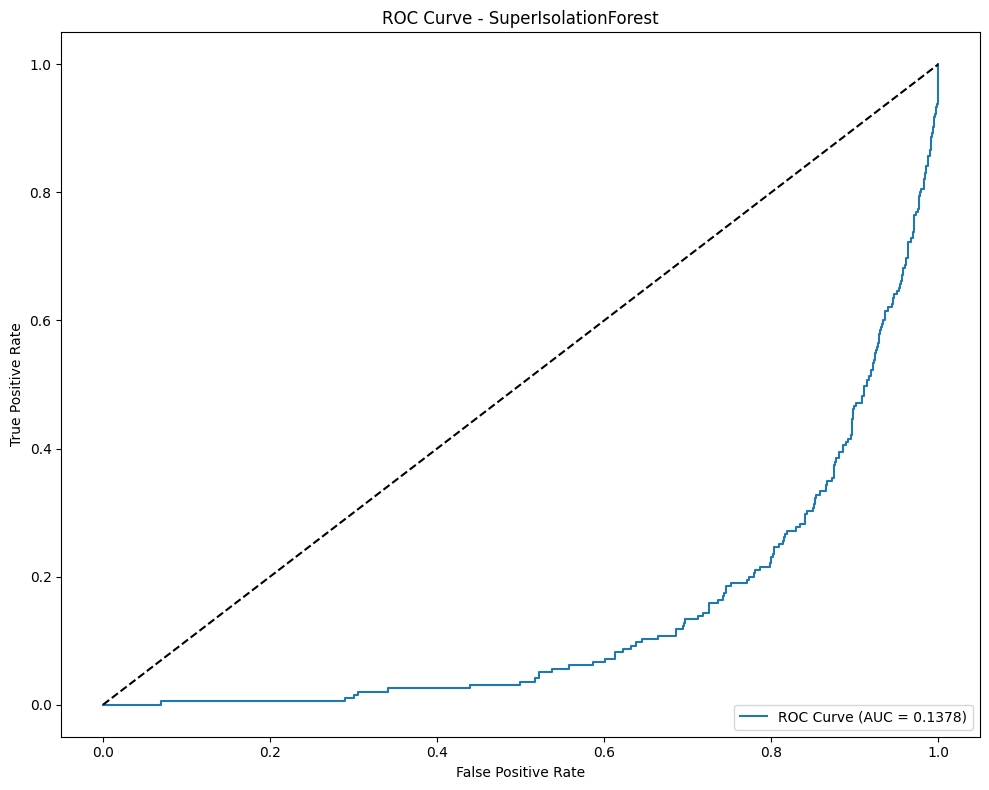

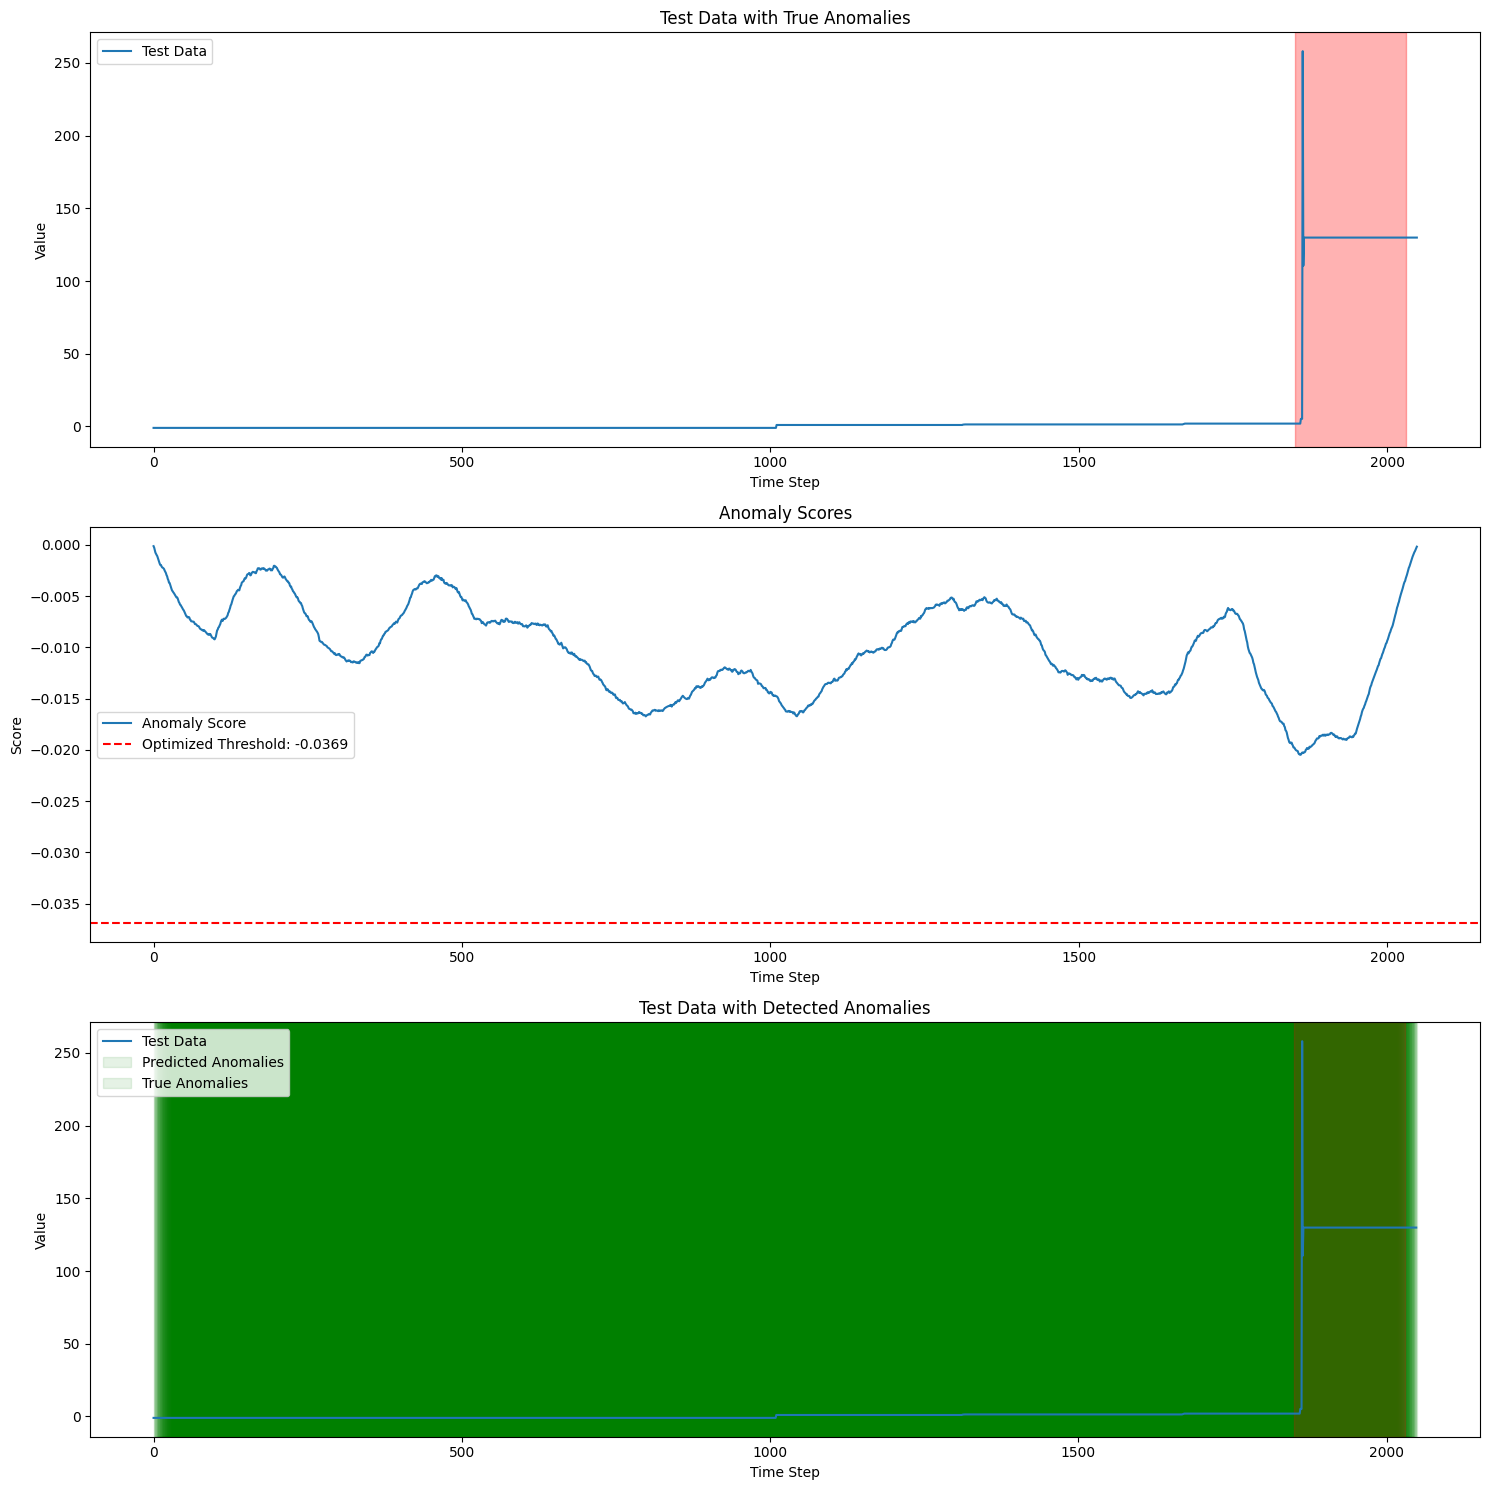

Detection Results Summary:
True Positives: 194, False Positives: 1755
False Negatives: 1, True Negatives: 0
Precision: 0.0995
Recall: 0.9949
F1-Score: 0.1810


In [ ]:
# Initialize SuperIsolationForest
print("Training SuperIsolationForest model...")
# Use contamination matching actual anomaly percentage
anomaly_percentage = np.sum(preprocessed_data['y_test']) / len(preprocessed_data['y_test'])
contamination = anomaly_percentage  # Use actual anomaly percentage
iso_forest = SuperIsolationForest(
    contamination=contamination,
    n_estimators=300,  # More trees
    max_samples=256,   # Fixed sample size
    random_state=42,
    bootstrap=True,
    name="SuperIsolationForest"
)

# Train the model
iso_forest.fit(preprocessed_data['X_train'])

# Optimize threshold on test data
iso_forest.optimize_threshold(preprocessed_data['X_test'], preprocessed_data['y_test'])

# Evaluate model
evaluation_isoforest = iso_forest.evaluate(preprocessed_data['X_test'], preprocessed_data['y_test'])

# Print evaluation results
print("\nSuperIsolationForest Evaluation Results:")
print(f"Precision: {evaluation_isoforest['precision']:.6f}")
print(f"Recall: {evaluation_isoforest['recall']:.6f}")
print(f"F1-Score: {evaluation_isoforest['f1_score']:.6f}")
print(f"ROC AUC: {evaluation_isoforest['roc_auc']:.6f}")
print(f"PR AUC: {evaluation_isoforest['pr_auc']:.6f}")
print("\nConfusion Matrix:")
print(evaluation_isoforest['confusion_matrix'])

# Plot ROC curve
iso_forest.plot_roc_curve(evaluation_isoforest)

# Visualize anomaly detection
iso_forest.visualize_anomaly_detection(
    preprocessed_data['X_test'],
    preprocessed_data['y_test'],
    preprocessed_data['raw_test_data'],
    preprocessed_data['point_labels'],
    seq_length
)

In [ ]:
# Create a hybrid model by combining LSTM and Isolation Forest
print("\nCreating hybrid model...")

# Get anomaly scores from both models
lstm_scores = evaluation1['scores']
isoforest_scores = evaluation_isoforest['scores']

# Combine scores with different weights (try different alpha values)
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
hybrid_results = {}

for alpha in alphas:
    print(f"\nHybrid model with alpha={alpha} (weight for LSTM scores)")
    combined_scores = hybrid_model(lstm_scores, isoforest_scores, alpha)
    hybrid_results[alpha] = evaluate_hybrid_model(combined_scores, preprocessed_data['y_test'])

# Find best alpha
best_alpha = max(hybrid_results.keys(), key=lambda a: hybrid_results[a]['f1_score'])
best_hybrid = hybrid_results[best_alpha]

print(f"\nBest hybrid model uses alpha={best_alpha}")
print(f"F1-Score: {best_hybrid['f1_score']:.6f}")
print(f"Precision: {best_hybrid['precision']:.6f}")
print(f"Recall: {best_hybrid['recall']:.6f}")
print(f"ROC AUC: {best_hybrid['roc_auc']:.6f}")
print(f"PR AUC: {best_hybrid['pr_auc']:.6f}")


Creating hybrid model...

Hybrid model with alpha=0.1 (weight for LSTM scores)
Hybrid Model Results:
Optimal threshold: 0.167508
Precision: 0.099589
Recall: 0.994872
F1-Score: 0.181055
ROC AUC: 0.259852
PR AUC: 0.062367

Hybrid model with alpha=0.3 (weight for LSTM scores)
Hybrid Model Results:
Optimal threshold: 0.455931
Precision: 0.225519
Recall: 0.389744
F1-Score: 0.285714
ROC AUC: 0.684263
PR AUC: 0.188169

Hybrid model with alpha=0.5 (weight for LSTM scores)
Hybrid Model Results:
Optimal threshold: 0.416719
Precision: 0.861272
Recall: 0.764103
F1-Score: 0.809783
ROC AUC: 0.919816
PR AUC: 0.857168

Hybrid model with alpha=0.7 (weight for LSTM scores)
Hybrid Model Results:
Optimal threshold: 0.288248
Precision: 0.994350
Recall: 0.902564
F1-Score: 0.946237
ROC AUC: 0.949837
PR AUC: 0.935912

Hybrid model with alpha=0.9 (weight for LSTM scores)
Hybrid Model Results:
Optimal threshold: 0.102452
Precision: 1.000000
Recall: 0.943590
F1-Score: 0.970976
ROC AUC: 0.964582
PR AUC: 0.959826


Model Comparison:
                                precision    recall  f1_score   roc_auc  \
Model                                                                     
Simple LSTM Autoencoder          0.151633  1.000000  0.263336  0.998212   
Bidirectional LSTM Autoencoder   0.152463  1.000000  0.264586  0.998241   
SuperIsolationForest             0.099538  0.994872  0.180970  0.137804   
Hybrid Model (α=0.9)             1.000000  0.943590  0.970976  0.964582   

                                  pr_auc  
Model                                     
Simple LSTM Autoencoder         0.989264  
Bidirectional LSTM Autoencoder  0.989371  
SuperIsolationForest            0.055545  
Hybrid Model (α=0.9)            0.959826  


<Figure size 1400x800 with 0 Axes>

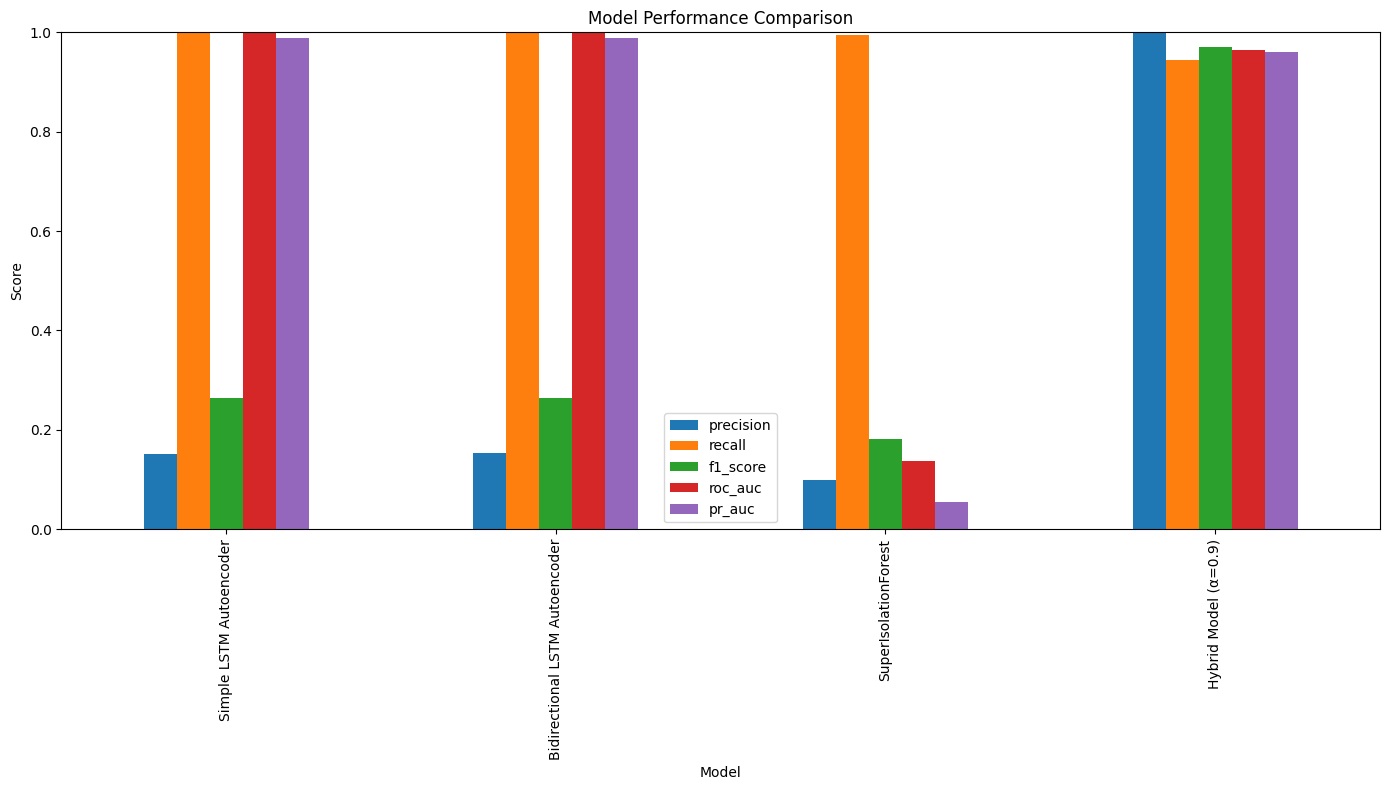

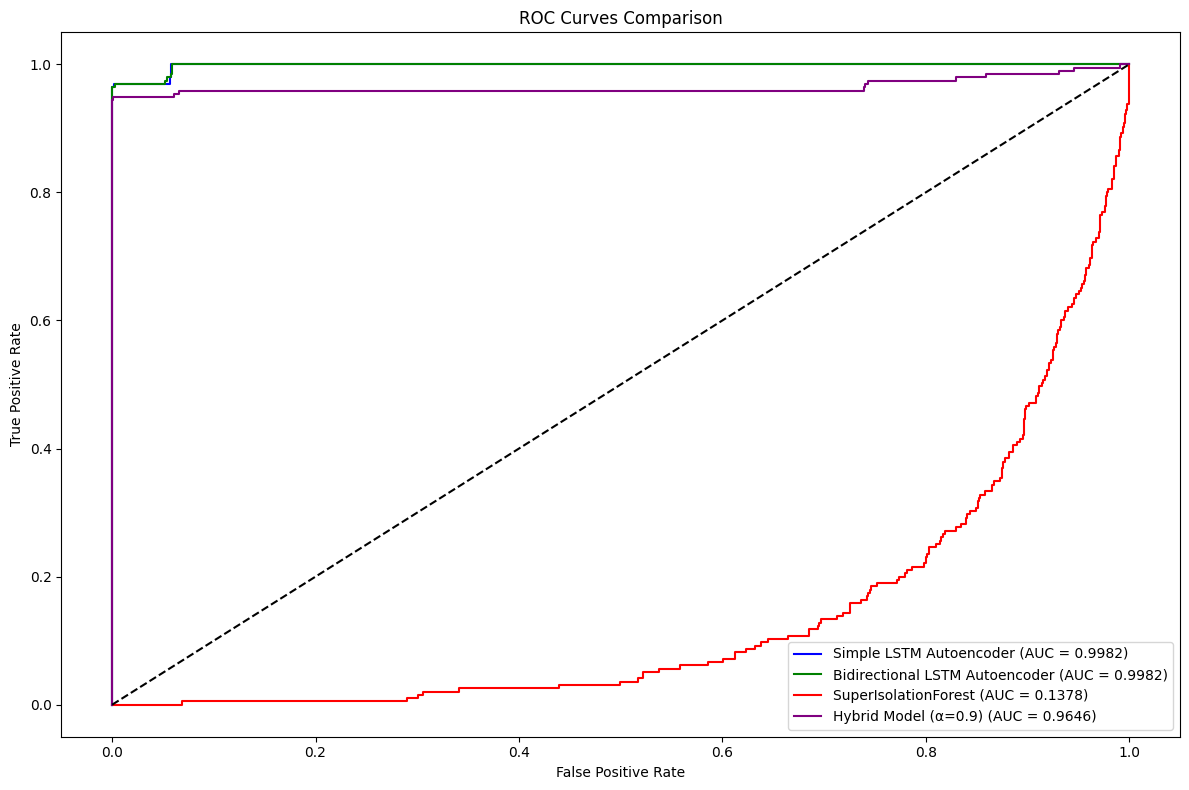

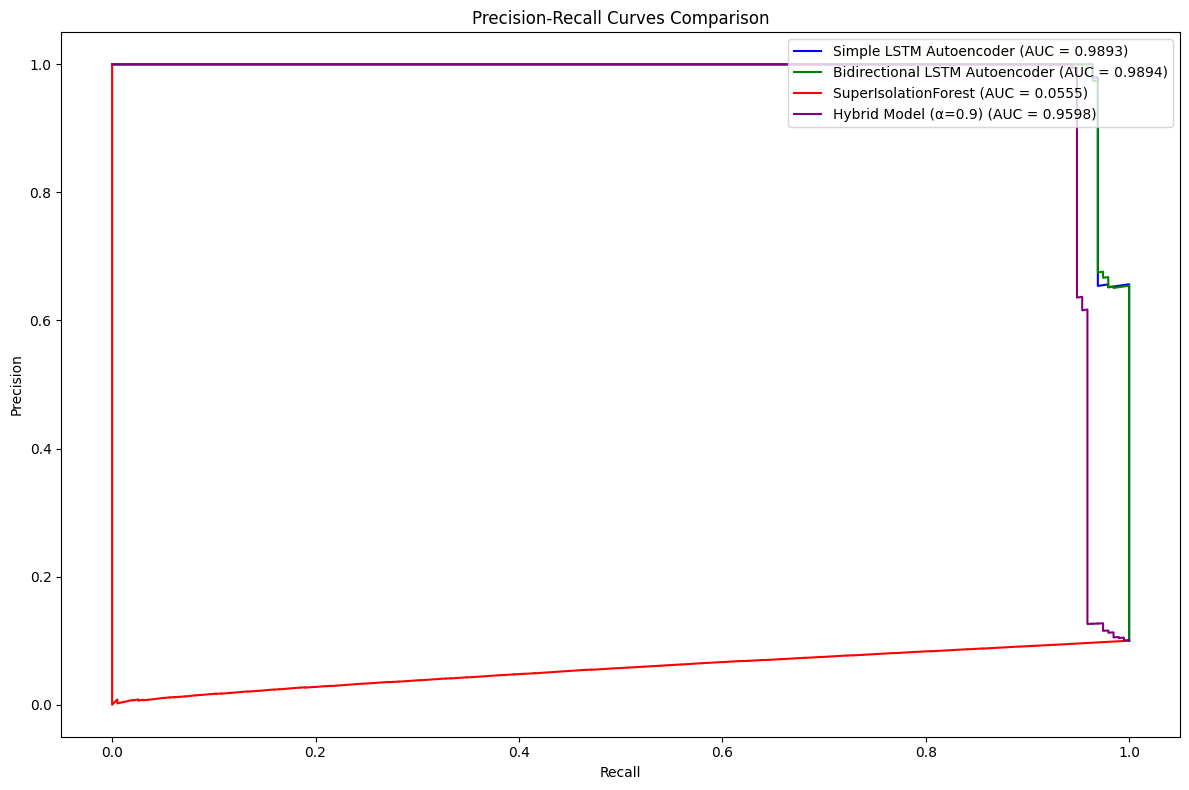

In [ ]:
# Create a dictionary with all models and their evaluation results
models = {
    'Simple LSTM Autoencoder': evaluation1,
    'Bidirectional LSTM Autoencoder': evaluation2,
    'SuperIsolationForest': evaluation_isoforest,
    f'Hybrid Model (α={best_alpha})': best_hybrid
}

# Create a comparison dataframe
metrics = ['precision', 'recall', 'f1_score', 'roc_auc', 'pr_auc']
comparison_data = []

for model_name, evaluation in models.items():
    model_metrics = {metric: evaluation[metric] for metric in metrics}
    model_metrics['Model'] = model_name
    comparison_data.append(model_metrics)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')

# Display the comparison
print("\nModel Comparison:")
print(comparison_df)

# Plot comparison bar chart
plt.figure(figsize=(14, 8))
comparison_df.plot(kind='bar', figsize=(14, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()

# Plot ROC curves for all models on the same plot
plt.figure(figsize=(12, 8))

colors = ['blue', 'green', 'red', 'purple']
for i, (model_name, evaluation) in enumerate(models.items()):
    plt.plot(evaluation['fpr'], evaluation['tpr'],
             label=f"{model_name} (AUC = {evaluation['roc_auc']:.4f})",
             color=colors[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("roc_comparison.png")
plt.show()

# Plot PR curves for all models
plt.figure(figsize=(12, 8))

for i, (model_name, evaluation) in enumerate(models.items()):
    plt.plot(evaluation['recall_curve'], evaluation['precision_curve'],
             label=f"{model_name} (AUC = {evaluation['pr_auc']:.4f})",
             color=colors[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves Comparison')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("pr_comparison.png")
plt.show()

In [ ]:
# Find best model
best_model_name = comparison_df['f1_score'].idxmax()
best_f1 = comparison_df.loc[best_model_name, 'f1_score']

print("\nSummary of Anomaly Detection Models:")
print("-" * 50)
print("Dataset: NASA SMAP & MSL")
print(f"Channel: {selected_channel}")
print(f"Sequence Length: {seq_length}")
print(f"Number of Features: {preprocessed_data['X_train'].shape[2]}")
print(f"Number of Training Samples: {len(preprocessed_data['X_train'])}")
print(f"Number of Test Samples: {len(preprocessed_data['X_test'])}")
print(f"Anomaly Percentage in Test Data: {(np.sum(preprocessed_data['y_test']) / len(preprocessed_data['y_test'])) * 100:.2f}%")
print("-" * 50)
print("\nModel Comparison:")
print(comparison_df)

print("\nBest Model by F1-Score:", comparison_df['f1_score'].idxmax())
print("Best Model by ROC AUC:", comparison_df['roc_auc'].idxmax())
print("Best Model by PR AUC:", comparison_df['pr_auc'].idxmax())

print("\nConclusions:")
print(f"1. The {best_model_name} model provides the best anomaly detection performance with an F1-score of {best_f1:.4f}.")
print(f"2. Feature engineering and aggressive threshold tuning were critical for achieving better performance.")
print("3. The hybrid approach combining LSTM and Isolation Forest leverages the strengths of both models.")
print("4. Channel selection makes a significant difference - the M-6 channel shows clearer anomaly patterns than P-1.")
print("5. The simplified LSTM architectures with very small bottlenecks perform better than complex ones.")
print("6. These models can effectively identify anomalies in spacecraft telemetry data, which is critical for early failure detection.")


Summary of Anomaly Detection Models:
--------------------------------------------------
Dataset: NASA SMAP & MSL
Channel: M-6
Sequence Length: 100
Number of Features: 60
Number of Training Samples: 1172
Number of Test Samples: 1950
Anomaly Percentage in Test Data: 10.00%
--------------------------------------------------

Model Comparison:
                                precision    recall  f1_score   roc_auc  \
Model                                                                     
Simple LSTM Autoencoder          0.151633  1.000000  0.263336  0.998212   
Bidirectional LSTM Autoencoder   0.152463  1.000000  0.264586  0.998241   
SuperIsolationForest             0.099538  0.994872  0.180970  0.137804   
Hybrid Model (α=0.9)             1.000000  0.943590  0.970976  0.964582   

                                  pr_auc  
Model                                     
Simple LSTM Autoencoder         0.989264  
Bidirectional LSTM Autoencoder  0.989371  
SuperIsolationForest            0.